In this notebook we will be going over how to calculate the risk of infection for indoor environments to familiarize ourselves with the parameters and functions. 

Our subject room will be Center Hall Room 101, a lecture hall at UC San Diego.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import truncnorm
import json
from IPython.display import Image
import pandas as pd



MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
SECONDS_IN_HOUR = 3600
FEET_IN_METER = 3.28084

In [2]:
#User Parameters
#Parameters that must be inputted by the User

#Number of occupants
#Room ID
room_id = 'CENTER 101'
#50 occupants is the reduced COVID-19 capacity.
n_occupants = 50 
#Speaker to Breathing Ratio (Default 1 to n for lecture with no discussion)
speaker_to_breathing_ratio = 1/n_occupants

#mask efficacy.
mask = {'none': 0,
                 'average': .7,
                 'high': .95}
mask_efficacy = mask['average']
#Duration in seconds
t = 1.25 * SECONDS_IN_HOUR
#Activity
activity = np.random.choice(['resting', 'light_exercise', 'moderate_exercise', 'heavy_exercise'])
#Social Distancing
social_distancing = True
#infection rate
#To calculate infection rate we will aggregate the past week of testing for our region, UC San Diego
#Source: https://returntolearn.ucsd.edu/dashboard/index.html
infection_rate = (2 + 11 + 10+ 3 + 7 + 10 + 12 + 5)/(20 + 1385 + 1375 + 286 + 1332 + 1414 + 944 + 1244)

#Age input. If not age is inputted an age distribution should be generated for the region. 
#Default age distribution is an empirical age distribution for a UCSD Classroom. 
    #Source: https://ir.ucsd.edu/_files/stats-data/profile/profile-2018-2019.pdf
occupant_age = np.random.choice([18, 19, 20, 21, 22, 23, 24, random.randint(25, 30)], size = n_occupants, p = [.198, .195, .195, .1875, .09375, .046875, .023875, .06])



In [3]:
#Building Parameters
room_table = pd.read_csv('data/room_data.csv')
room_table.fillna(np.nan)
#Room Area in square ft.
room_area = room_table.loc[room_table['Room'] == room_id]['Area'].item()
#Room Height (Center 101 has a slopes downwards so we are calculating average for height) in ft.
#impute null values with average ceiling height of 10 ft
room_hght = room_table.loc[room_table['Room'] == room_id]['Height'].item()
if room_hght == 'nan':
    room_hght = 10
#Passive ventilation rate Standard: 0.35 ACH Range: 0–1 ACH
#Average assumed to be .35 based on survey of research
#Source: https://www.aivc.org/sites/default/files/members_area/medias/pdf/Airbase/airbase_00250.pdf, 
#        https://doi.org/10.1016/j.buildenv.2011.12.017
pass_vent_rate = .35
#CFM range
cfm_range = room_table.loc[room_table['Room'] == room_id]['VAV'].item()
#Windows


In [4]:
str(room_table.loc[room_table['Room'] == 'TATA2102']['Height'].item())

'nan'

In [5]:
# Assumptions

#Wet aerosol diameter Standard: 5 Range: 2–10 µm
#Source:
wet_asl_d = 5
#Virus lifetime in aerosol Standard: 1.7 Range: 0.6–2.6 Hours
#Source
virus_life = 1.7
#Viral load “highly infectious” Standard: 5 × 10^8 Range: 10^8–10^9 RNA Copies/cm3
#Source:
hi_viral_load = 5e8
#Viral load “super infectious” Standard: 5 × 10^9 Range: 10^9–10^10 RNA Copies/cm3
#source:
si_viral_load = 5e9
#Deposition probability in lungs Standard 0.5 Range: 0.2–0.8
#Source:
if social_distancing:
    deposition_prob = .5
#Infective dose (D50) Standard: 316 Range: 100–1000 RNA copies
#Source:
d50 = 316

In [6]:
#Helper Functions

#Used to generate values with normal distribution
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def get_air_changes_per_hour(cfm, room_volume):
    if str(cfm) == 'nan':
        #impute unknown cfm with arbitrary cfm
        print('VAV unknown. Imputed with arbitrary VAV of 800 CFM')
        cfm = 800
    return (cfm * 60) / room_volume

In [7]:
def generate_occupants(n_occupants, speaker_to_breathing_ratio, occupant_age = occupant_age, masks_efficacy = mask_efficacy):
    occupants = {}
    for i in range(n_occupants):
        curr_occ = "occ" + str(i)
        occupants[curr_occ] = {}
        occupants[curr_occ]['age'] = occupant_age[i]
        #Here we must change respiratory function to reflect exercise
        #Normal breathing/speaking/singing concentrations
        #Concentration from breathing Standard: 0.1 Range: 0.06–1.0 cm−3 Distribution: Normal
        #Source:
        normal_breathing = get_truncated_normal(mean=.1, sd=.02, low=.06, upp=1)
        occupants[curr_occ]['conc_breathing'] = normal_breathing.rvs()
        #Concentration from speaking (singing) Standard: 1.1 Range: 0.06–6.0 cm−3 Distribution: Normal
        #Source:
        normal_speaking = get_truncated_normal(mean=1.1, sd=.02, low=.06, upp=6)
        occupants[curr_occ]['conc_speaking'] = normal_speaking.rvs()
        #Respiratory rate standard: 10 Range: 5–20 L/min Distribution: Normal
        #Source:
        normal_respiratory_rate = get_truncated_normal(mean= 10, sd=5, low=5, upp=20)
        occupants[curr_occ]['norm_resp_rate'] = normal_respiratory_rate.rvs()
        occupants[curr_occ]['mask_efficacy'] = masks_efficacy
        occupants[curr_occ]['testedWeekly'] = True
    return occupants

In [8]:
occupants = generate_occupants(n_occupants, speaker_to_breathing_ratio)

In [9]:
occupants['occ0']

{'age': 22,
 'conc_breathing': 0.09643145126557937,
 'conc_speaking': 1.1163322924446928,
 'norm_resp_rate': 17.44143588081179,
 'mask_efficacy': 0.7,
 'testedWeekly': True}

To calculate the risk of infection in a given room, the emmission rate of quanta is needed. A quantum is defined as the viral load i.e. the dose of airborne droplet nuclei required to cause infection in 63% of persons. 
The emmission rate is caclulated with the following formula

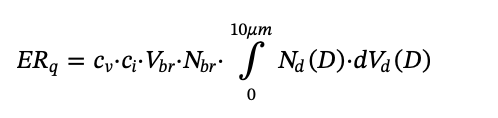

In [10]:
#Formula for calulating Emission Rate 
#Source: https://doi.org/10.1016/j.envint.2020.105794
Image(filename='images/formula.png') 

In [11]:
#Cv or viral load in sputum is in RNA copies per mL. 
#Source: 
viral_load_sptm = np.nan

#Ci is a conversion factor defined as the ratio between one infectious quantum and the infectious dose expressed
#in viral RNA copies
#Source: 
ci = np.nan

#Vbr is the volume of exhaled air per breath in cubic meters 
vol_exhale = occupants['occ0']['conc_speaking']

#Nbr is the breathing rate in breaths per hour
breath_rate = occupants['occ0']['norm_resp_rate']

#Inhalation (IR) is the product of breathing rate (Nbr) and tidal volume (Vbr)
#IR is a dependent on the activity of the infected subject. 

#Nd is the droplet number concentration in particles per cubic meter

In [12]:
#Vd(D) is the volume of a single droplet as a function of droplet diameter
#Source: https://doi.org/10.1016/j.jaerosci.2008.11.002
droplet_diameters = data = {'talking':  
                                                {'.8μm': .236, '1.8μm': .068, '3.5μm': .007, '5.5μm': .011},
                            'whisper':
                                                {'.8μm': .110, '1.8μm': .014, '3.5μm': .004, '5.5μm': .002},
                            'singing':
                                                {'.8μm': .751, '1.8μm': .139, '3.5μm': .139, '5.5μm': .059},
                            'breathing':
                                                {'.8μm': .084, '1.8μm': .009, '3.5μm': .003, '5.5μm': .002},  
                           }



In [13]:
#Average quanta emission rates averaged between men and women based on activity
#Emission rates are given in cubic meters per hour
#Source: https://ww2.arb.ca.gov/sites/default/files/classic//research/apr/past/a033-205.pdf
quanta_emission = {'resting': .49,
                   'standing': .54,
                   'light_exercise': 1.38,
                   'moderate_exercise': 2.35,
                   'heavy_exercise': 3.30}

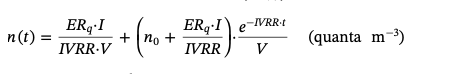

In [14]:
#Formula for calulating quanta
#Source: https://doi.org/10.1016/j.envint.2020.105794
Image(filename='images/formula1.png')


where IVRR (h−1) represents the infectious virus removal rate in the space investigated, n0 represents the initial number of quanta in the space, I is the number of infectious subjects, V is the volume of the indoor environment considered, and ERq is the abovementioned quanta emission rate (quanta h−1) characteristic of the specific disease/virus under investigation

As of the current date the infection rate for UC San Diego students is 11 cases / 11 / 1,385 tests. That means the probability of any given student to be infected is 0.79%. If we assume our number of occupants to 21, our estimated number of infected occupants would be this would give 0.166. So when the n_occupants is too small to produce <= 1 using the infection rate, we will assume 1 infected occupant to estimate risk unless otherwise specified. 

In [15]:
n_infected = infection_rate * n_occupants
if n_infected < 1:
    n_infected = 1

The infectious virus removal rate (IVRR) is the sum of three contributions (Yang and Marr, 2011): the air exchange rate (AER) via ventilation, the particle deposition on surfaces (k, e.g. via gravitational settling), and the viral inactivation (λ).

In [17]:
list(cfm_range)

['[', '3', '5', '0', '0', ',', '7', '0', '0', '0', ']']

In [81]:
#VAV cubic feet of air per minute (CFM) ranges frmo 3,500 - 7,000 in Center 101
#Source Prof. Rajesh Gupta
cfm = np.random.choice(cfm_range)
air_change_rate_range = get_air_changes_per_hour(cfm, room_volume)
print(air_change_rate_range)
#Change units

# Deposition rate is determined by the ratio of the settling velocity of the micrometric particles (1e-4 m/s) and 
#the height of the emmission source (average height of a person is 1.5 m)
# Source https://doi.org/10.1016/j.culher.2019.02.017
deposition_rate = 1e-4 * FEET_IN_METER
print(deposition_rate)

#Viral Inactivation refers to the amount of time the virus "survives" in aerosol
#Source: https://www.nejm.org/doi/10.1056/NEJMc2004973
#.63 inactivation per hour
viral_inactivation = .63 * SECONDS_IN_HOUR
print(viral_inactivation)

#Infectious virus removal rate
ivrr = air_change_rate + deposition_rate + viral_inactivation
print(ivrr)
#n0 represents the initial quanta in a space
#TODO: Find initial quanta - Use zero as placeholder
#Source: 
initial_quanta = 0

#V is volume of room
room_volume = room_area * room_hght


ValueError: 'a' must be 1-dimensional or an integer

In [68]:
def quanta_concentration(I, ERq, IVRR, V, n0, t):
    return float(((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e **(-IVRR * t)) / V))

In [69]:
quanta_concentration(n_infected, quanta_emission[activity], ivrr, room_volume, initial_quanta, t)

NameError: name 'ivrr' is not defined

In [109]:
fig = plt.figure()
ax = plt.axes()


f2 = np.vectorize(quanta_concentration) 


x = np.linspace(0, t)
ax.plot(x, f2(n_infected, quanta_emission[activity], ivrr, room_volume, initial_quanta, x));

SyntaxError: invalid syntax (<ipython-input-109-7d294a3eacf5>, line 5)

#### Calculating max amount of people allowed in room given exposure time & max exposure time given a capacity

In [122]:
# Physical Parameters
floor_area = room_area  # ft2
mean_ceiling_height = room_hght  # ft
air_exchange_rate = air_change_rate  # /hr (air changes per hour (ACH))
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = [0.9997, 0.1, 0]  # HEPA,MERVs,no filter
relative_humidity = 1 - 0.6
room_vol = floor_area * mean_ceiling_height #ft3

In [123]:
#parameters
breathing_flow_rate = 0.5 #meters/hour
max_aerosol_radius = 2 #micrometers
mask_passage_prob = [1,0.3,0.05] #no mask, cloth, N95
exhaled_air_inf = quanta_emission['standing'] * 100 #infection quanta/meter #follow quanta_emission dict to calc
max_viral_deact_rate = 0.6 # per hour
room_vol_m = 0.0283168 * room_vol #meters
mean_ceiling_height_m = mean_ceiling_height * 0.3048 #meters
risk_tolerance = 0.1 #expected transmissions per infector
air_exch_rate = air_exchange_rate #per hour

In [124]:
#calculations
eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
sett_speed_mm = 3 * (eff_aerosol_radius / 5) ** 2 #mm/s
sett_speed = sett_speed_mm * 60 * 60 / 1000  # m/hr
viral_deact_rate = max_viral_deact_rate * relative_humidity
fresh_rate = room_vol * air_exch_rate / 60
recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)
air_filt_rate = aerosol_filtration_eff[1] * recirc_rate * 60 / room_vol #have to specify which filtration we have
conc_relax_rate = air_exch_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m
airb_trans_rate = ((breathing_flow_rate * mask_passage_prob[1]) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate) #have to specify what kind of mask usage

In [125]:
#Calculate maximum people allowed in the room given an exposure time (hours)
#steady state model
def calc_n_max_ss(exp_time): #exp time in hrs
    #risk_tolerance = risk_tolerance  
    n_max = 1 + risk_tolerance / (airb_trans_rate * exp_time)
    return n_max

#transient model
def calc_n_max_t(exp_time): #exp time in hrs
    risk_tolerance = risk_tolerance 
    n_max = 1 + (risk_tolerance * (1 + 1/(conc_relax_rate * exp_time)) / (airb_trans_rate * exp_time))
    return n_max

In [126]:
#Calculate maximum exposure time allowed given a capacity (# people):
def calc_max_time(n_max):
    #risk_tolerance = risk_tolerance

    exp_time_ss = risk_tolerance / ((n_max - 1) * airb_trans_rate)  # hrs, steady-state
    exp_time_trans = exp_time_ss * (1 + (1 + 4 / (conc_relax_rate * exp_time_ss)) ** 0.5) / 2  # hrs, transient
    return exp_time_trans

In [128]:
calc_max_time(750)

13.80163686440887